In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import pandas as pd
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import sklearn
from itertools import permutations
from pprint import pprint
from PIL import Image
import PIL
import pyodbc
from tqdm import tqdm
from random import random
from random import randrange
import math
import seaborn as sns
from matplotlib.lines import Line2D
from torchsummary import summary


In [2]:
plt.ion()   # interactive mode
testimages = list()
testclasses = list()
testindices = list()
testinitialized = 0
PATH = './test_net4.tar'
ndepth = 4
nminibatchsize = 4
classes = ('Hospitalized','Intubated','Deceased','Pneumonia')
columns = ('Male','Pregnant','Diabetes','Asthma','Immunocompromised'
            ,'Hypertension','Other Disease','Cardiovascular Disease','Obesity','Kidney Disease'
            ,'Tobacco Use','COPD')
nclasses = len(classes)
ncolumns = len(columns)
testratio = 0.6 #randomly select this proportion of the dataset to be test data

In [3]:
nfeatures = 1.0
for i in range(ndepth-1):
    nfeatures *= (ncolumns - i)
nimgsize = math.ceil(nfeatures**0.5)
npix = nimgsize**2
normtuple = list()
for i in range(ndepth): normtuple.extend([0.5])
normtuple = tuple(normtuple)

print('total features: %i; image size: %i x %i x %i' % (nfeatures,nimgsize,nimgsize,ndepth))
print('image normalization tuple:')
print(normtuple)

total features: 1320; image size: 37 x 37 x 4
image normalization tuple:
(0.5, 0.5, 0.5, 0.5)


In [4]:
def getlabelval(labeldata):
    retval = np.array(list(labeldata),dtype=np.float32)
    return retval

def createimagetensor(row=None):
    if row:
        icol = 0
        irow = 0
        if len(list(row[0])) != ncolumns: raise CustomError('Invalid Input Size: Expected %i, Received %i' % (ncolumns,len(list(row[0]))))
        if len(row) < 2: raise CustomError('Invalid Data: Expected row format is [bindata,age,labels(optional)]')
        imgdata = np.zeros((nimgsize,nimgsize,ndepth),dtype=np.float32)
        for px in permutations(list(row[0]),ndepth-1):
            thispx = list()
            for chan in px: thispx.extend([float(chan)])
            thispx.extend([float(row[1])/100.])
            imgdata[icol,irow,:] = thispx
            irow += 1
            if (irow > nimgsize - 1):
                icol += 1
                irow = 0
        return TF.normalize(TF.to_tensor(imgdata),normtuple,normtuple)
    else:
        return None

class CustomError(Exception):
    pass


In [5]:
#create generator function for data acquisition and conversion to torch image format.
#function must return a tuple of form (tensor containing 4 images,tensor containing 4 labels)
#also builds a test set using a quick and dirty random number method.  this will need to be 
#improved to balance both the test and train sets across potential labels.

def nextrow():
    conn = pyodbc.connect('DSN=covid;UID=seh;PWD=Welcome2020!;')
    crsr = conn.cursor()
    crsr.execute("{CALL getpydatav2}")
    rowcnt = 0
    imgs = list()
    labels = list()
    row = [0,1,2]
    idx = 0
    while row:
        while (rowcnt<nminibatchsize):
            if testinitialized == 1 and idx in testindices:
                crsr.skip(nminibatchsize)
                row = [0,1,2]
                break
            else:
                try:
                    row = crsr.fetchone()
                except:
                    conn = pyodbc.connect('DSN=covid;UID=seh;PWD=Welcome2020!;')
                    crsr = conn.cursor()
                    crsr.execute("{CALL getpydatav2}")
                    crsr.skip(idx*nminibatchsize + rowcnt)
                    row = crsr.fetchone()
                rowcnt += 1
                if row:
                    imgtensor = createimagetensor(row)
                    labels.append(np.array(list(row[2]),dtype=np.float32))
                    imgs.append(imgtensor)
                else:
                    break
        if row:
            if (testinitialized == 0):
                if (random() < testratio):
                    testimages.append(torch.stack(imgs))
                    testclasses.append(torch.tensor(labels))
                    testindices.append(idx)
                else:
                    yield torch.stack(imgs),torch.tensor(labels)
            elif (idx not in testindices):
                yield torch.stack(imgs),torch.tensor(labels)
            rowcnt = 0
            idx += 1
            imgs = list()
            labels = list()
        else:
            break


In [6]:
#create generator function for test set
def gentestdata(startindex = 0):
    for i,clss in enumerate(testclasses[startindex:],startindex):
        yield testimages[i],clss

def gettestdata(idx = 0):
    return testimages[idx],testclasses[idx]

def createfakedata(age=None, conds=None):
    if age is None: age = randrange(15,90)
    elif isinstance(age,tuple): age = randrange(age[0],age[1])
    bindata = ''
    if isinstance(conds,list):
        for col in columns:
            bindata += ('1' if col in conds else '0') 
        return createimagetensor([bindata,age]).unsqueeze(0)
    elif isinstance(conds,str):
        for col in columns:
            bindata += ('1' if col in conds else '0') 
        return createimagetensor([bindata,age]).unsqueeze(0)
    totconds = (conds if isinstance(conds,int) and conds < ncolumns else math.floor(ncolumns*random()))
    condsapplied = 0
    for i,col in enumerate(columns):
        if condsapplied < totconds:
            if random() >= 0.5:
                if i == 1 and (age < 12 or age > 55 or bindata[0] == '1'):
                    bindata += '0'
                else:
                    bindata += '1'
                    condsapplied += 1
            else:
                bindata += '0'
        else:
            bindata += '0'
    return createimagetensor([bindata,age]).unsqueeze(0)

In [7]:

class Net(nn.Module):

    def __init__(self, modelinputtensor, layerlist, layerparams):
        """
        torch.nn must be imported as nn
        torch.nn.functional must be imported as F
        modelinputtensor = example model input tensor (including an arbitrary batch dimension)
        layerlist = list of pytorch nn fucntions as their 'F' namespace equivalents (e.g. 'nn.MaxPool2d' should be supplied as 'F.max_pool2d') 
        layerparams = list of _independent_ params in their nn form and passed as a tuple.  Example:
            The first conv2d layer will have 3 params in a tuple of form (in_channels, out_channels, kernel_size). 
            Subsequent conv2d layers will have _2_ params in a tuple of form (out_channels, kernel_size) since the in_channels will be determined by the previous layer. 
            Pooling layers will always have params of the form (x, y) corresponding to the pooling window size.
            Linear layers will always have a single param corresponding to the number of out features for the layer (input features are determined by the preceding layer)
        """
        super(Net, self).__init__()
        self.lyrs, self.fwdlyrs = self.getlayers(modelinputtensor,layerlist,layerparams)

    def forward(self, x):
        for f in self.fwdlyrs:
            x = eval(f)
        return F.sigmoid(x)

    def getlayers(self,testtensor,funcs=[],params=[],debug=0):
        initlayers = nn.ModuleList()
        fwdlayers = list()
        if debug == 1: print(testtensor.size())
        lastsize = None
        lyr = 0
        with torch.no_grad():
            for fn,pa in zip(funcs,params):
                if lastsize is not None:
                    if fn.__name__ == 'conv2d':
                        pa = (lastsize[1],pa[0],pa[1])
                    elif fn.__name__ == 'linear':
                        if not testtensor.ndim == 2:
                            testtensor = testtensor.view(-1,self.numflatfeatures(testtensor))
                            fwdlayers.append("x.view(-1,self.numflatfeatures(x))")
                            lastsize = testtensor.size()
                        pa = (lastsize[1],pa)        
                if fn.__name__ == 'conv2d':
                    paeval = "torch.tensor(np.random.rand(" + ",".join(tuple(map(str,(pa[1],pa[0],pa[2],pa[2])))) + "),dtype=torch.float32)"
                elif fn.__name__ == 'max_pool2d':
                    paeval = ",".join(tuple(map(str,pa)))
                elif fn.__name__ == 'linear':
                    paeval = "torch.tensor(np.random.rand(" + ",".join(tuple(map(str,(pa[1],pa[0])))) + "),dtype=torch.float32)"
                if not fn.__name__ == 'linear' or pa[0] > pa[1]:
                    testtensor = fn(testtensor,eval(paeval))
                    lastsize = testtensor.size()
                    initlayers.append(eval(self.getinitequivalent(fn.__name__,pa)))
                    fwdlayers.append(self.getfwdequivalent(fn.__name__,lyr))
                    lyr += 1
                    if debug == 1: print(testtensor.size())
                elif debug == 1: print('Eliminating linear layer - out features > previous layer')
        fwdlayers[-1] = 'self.lyrs[' + str(lyr - 1) + '](x)'
        return initlayers,fwdlayers

    def numflatfeatures(self,x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def getinitequivalent(self,funcname,initparams):
        return 'nn.' + ''.join([val.capitalize() for val in funcname.split('_')]) + '(' + ",".join(tuple(map(str,initparams))) + ')'

    def getfwdequivalent(self,funcname,lyrnum):
        if not funcname == 'max_pool2d':
            return 'F.relu(self.lyrs[' + str(lyrnum) + '](x))'
        else:
            return 'self.lyrs[' + str(lyrnum) + '](x)'




In [8]:
def getconvlayers(firstdepth=4,maxlayers=5,minlayers=2,maxkernel=7,minkernel=3,maxoutchan=12,minoutchan=4):
    fncs,parms = list(),list()
    fncs.append(F.conv2d)
    parms.append((firstdepth,np.random.randint(minoutchan,maxoutchan+1),np.random.randint(minkernel,maxkernel+1)))
    for i in range(np.random.randint(minlayers-1,maxlayers)):
        fncs.append(F.conv2d)
        parms.append((np.random.randint(minoutchan,maxoutchan+1),np.random.randint(minkernel,maxkernel+1)))
    return fncs,parms

def getlinlayers(initoutfeatures,featuredeadband=20,maxlayerdivisor=20,minlayerdivisor=4):
    fncs,parms = list(),list()
    fncs.append(F.linear)
    parms.append(initoutfeatures)
    nextoutfeatures = int(initoutfeatures/np.random.randint(minlayerdivisor,maxlayerdivisor+1)) 
    while nextoutfeatures > nclasses + featuredeadband:
        fncs.append(F.linear)
        parms.append(nextoutfeatures)
        nextoutfeatures = int(nextoutfeatures/np.random.randint(minlayerdivisor,maxlayerdivisor+1))
    fncs.append(F.linear)
    parms.append(nclasses)
    return fncs,parms

In [26]:
datlist = []
for i in range(4):
    datlist.append(createfakedata(40,["Diabetes"]).squeeze(0))
testtensor = torch.stack(datlist)
optimizers = [("optim.SGD(d['net'].parameters(), lr=0.0001, momentum=0.9)","SGD p=0.9"),
              ("optim.SGD(d['net'].parameters(), lr=0.0001, momentum=0.9,nesterov=True)","SGD nesterov"),
              ("optim.SGD(d['net'].parameters(), lr=0.0001, momentum=0.1)","SGD p=0.1"),
              ("optim.Adam(d['net'].parameters(), lr=0.0001)","Adam"),
             ]
def createtestnets(netcount=50,**kwargs):
    netdict = dict()
    for i in tqdm(range(netcount)):
        cfs, cps = getconvlayers()
        lfs, lps = getlinlayers(1000)
        funcs = cfs
        params = cps
        if random() > 0.3:
            funcs.extend([F.max_pool2d])
            poolsize = np.random.randint(2,4)
            params.extend([(poolsize,poolsize)])
        funcs.extend(lfs)
        params.extend(lps)
        for opt in optimizers:
            d = dict()
            d['net'] = Net(testtensor,funcs,params)
            d['criterion'] = nn.BCELoss()
            d['optimizer'] = eval(opt[0])#optim.SGD(d['net'].parameters(), lr=0.0001, momentum=0.9)
            #print(summary(d['net'],(ndepth,nimgsize,nimgsize)))
            netdict[str(i) + '-' + opt[1]] = d
    return netdict

#print([(netdef['params'],netdef['net'].lyrs) for netdef in createtestnets(10).values()])
netcount = 3
netdict = createtestnets(netcount)
funcs = [F.conv2d,F.conv2d,F.max_pool2d,F.linear,F.linear,F.linear]
params = [(4,12,5),(48,5),(2,2),578,34,4]
for opt in optimizers:
    d = dict()
    d['net'] = Net(testtensor,funcs,params)
    d['criterion'] = nn.BCELoss()
    d['optimizer'] = eval(opt[0])#optim.SGD(d['net'].parameters(), lr=0.0001, momentum=0.9)
#print(summary(d['net'],(ndepth,nimgsize,nimgsize)))
    netdict[str(netcount) + '-' + opt[1]] = d
        

100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


In [27]:
pprint(print(summary(netdict[str(netcount) + '-Adam']['net'],(ndepth,nimgsize,nimgsize))))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 33, 33]           1,212
            Conv2d-2           [-1, 48, 29, 29]          14,448
         MaxPool2d-3           [-1, 48, 14, 14]               0
            Linear-4                  [-1, 578]       5,438,402
            Linear-5                   [-1, 34]          19,686
            Linear-6                    [-1, 4]             140
Total params: 5,473,888
Trainable params: 5,473,888
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.48
Params size (MB): 20.88
Estimated Total Size (MB): 21.39
----------------------------------------------------------------
None
None


In [28]:
#train a series of layer configurations and record loss data
validationfreq = 1000
validationcnt = 1000
lossrecrate = 10
lossdict = dict()
#for epoch in range(2):  # loop over the dataset multiple times
for k,d in netdict.items():
    net = d['net']
    criterion = d['criterion']
    optimizer = d['optimizer'] 
    tlosslist = []
    vlosslist = []
    last_loss = 0.0
    lasttestidx = 0
    running_loss = 0.0
    testcnt = 0
    rowgen = nextrow()
    pbar = tqdm(enumerate(rowgen),total=validationfreq-1)
    for i, data in pbar:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        #print((outputs,labels))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % lossrecrate == lossrecrate - 1:
            tlosslist.append((running_loss-last_loss)/lossrecrate)
            last_loss = running_loss
        if i % validationfreq == validationfreq - 1:    # print every 100 mini-batches
            #tqdm.write('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            last_loss = 0.0
            valid_loss = 0.0
            net.eval()
            with torch.no_grad():
                randomstartindex = 0#math.floor(len(testimages)*random())
                genfunc = gentestdata(randomstartindex)
                for j, (tin,tlab) in enumerate(genfunc):
                    lasttestidx = j + 1
                    outputs = net(tin)
                    loss = criterion(outputs,tlab)
                    valid_loss += loss.item()
                    if j % lossrecrate == lossrecrate - 1:
                        vlosslist.append((valid_loss-last_loss)/lossrecrate)
                        last_loss = valid_loss
                    if j % validationcnt == validationcnt - 1: break
            pbar.set_description(desc='net name: %s; loss: %.3f; validation loss: %.3f' 
                                        % (k, running_loss/validationfreq, valid_loss/lasttestidx))
            lossdict[k] = {'trainlosses':tlosslist,
                           'validlosses': vlosslist,
                           'trainlossavg': running_loss / validationfreq,
                           'validlossavg': valid_loss / lasttestidx}
            
            running_loss = 0.0
            last_loss = 0.0
            net.train()
            break
        pbar.update()
    net.eval()
    testinitialized = 1
#save test set and model state dictionary for loading later without training.
#torch.save({'model_state_dict':net.state_dict(),
#            'testimages': testimages,
#            'testclasses': testclasses,
#            'testindices': testindices}, PATH)
print('Finished Training')

100%|██████████| 1999/1999 [04:05<00:00,  8.16it/s]


TypeError: %d format: a number is required, not str

In [29]:
print('net name: %s; loss: %.3f; validation loss: %.3f' 
                                        % (k, running_loss/validationfreq, valid_loss/lasttestidx))

net name: 0-SGD p=0.9; loss: 0.600; validation loss: 0.491


In [19]:
#print(goodnets[0]['net'].lyrs)
netdf = pd.DataFrame(columns=['netnum','iteration','loss','losstype'])
loc = 0
for k,gnet in netdict.items():
    for i,loss in enumerate(lossdict[k]['trainlosses']):
        netdf.loc[loc] = pd.Series({'netnum':k,'iteration':i,'loss':loss,'losstype':'train'})
        loc += 1
    for i,loss in enumerate(lossdict[k]['validlosses']):
        netdf.loc[loc] = pd.Series({'netnum':k,'iteration':i,'loss':loss,'losstype':'test'})
        loc += 1
#agedf.loc[0] = pd.Series({'age':0,'type':'Predicted','result':'Deceased'})
#print(netdf.iloc[0:50])

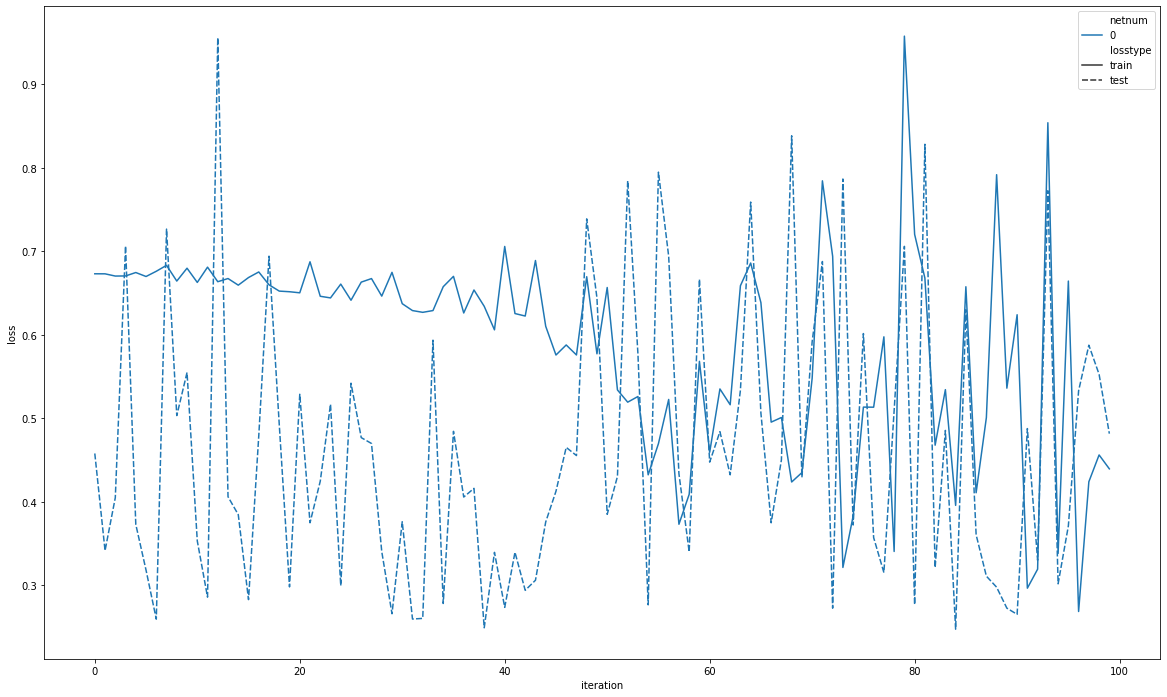

In [24]:
fig, ax = plt.subplots(1,1,figsize=(20,12))
sns.lineplot(x='iteration', y='loss', hue='netnum', style='losstype', data=netdf.query('netnum==0'))


In [ ]:
def interpretimagetensor(imgtensor):
    ptsdata = list()
    for (bindata,age) in getbindatafromimagetensor(imgtensor):
        ptdata = str(int(age)) + ' yo, '
        for i, val in enumerate(list(bindata)):
            if i == 0:
                if val == '1':
                    ptdata += 'Male, '
                else:
                    ptdata += 'Female, '
            elif val == '1':
                ptdata += columns[i] + ', '
        ptdata = ptdata[:-2]
        ptsdata.append(ptdata)
    return ptsdata

def getbindatafromimagetensor(imgtensor):
    ptsdata = list()
    for case in imgtensor:
        case = case / 2 + 0.5
        case = case.numpy()
        case = np.transpose(case, (1, 2, 0))
        bindata = ''
        for i in range(ndepth-1): bindata += str(int(case[0,0,i]))
        for i in range(1,ncolumns - ndepth + 2):
            bindata += str(int(case[0,i,ndepth-2]))
        age = float(round(float(case[0,0,ndepth-1])*100.))
        ptsdata.append((bindata, age))
    return ptsdata


In [ ]:
#skip training and load saved model
checkpoint = torch.load(PATH)
net = Net()
net.load_state_dict(checkpoint['model_state_dict'])
testimages = checkpoint['testimages']
testclasses = checkpoint['testclasses']
testindices = checkpoint['testindices']
testinitialized = 1
net.eval()

In [ ]:
#test random image from test set
net.eval()
randomstartindex = math.floor(len(testimages)*random())
print(randomstartindex)
images, labels = gettestdata(randomstartindex)

with torch.no_grad():
    outputs = net(images)
    ptinfo = interpretimagetensor(images)
    for i in range(nminibatchsize):
        actlist = list()
        predlist = list()
        if sum(labels[i]) == 0.:
            actlist.append('none')
        for j in range(nclasses):
            predlist.extend([str(round(100*float(outputs[i,j]),2)) + '% ' + classes[j]])
            if labels[i,j] == 1.: actlist.extend([classes[j]])
        print(ptinfo[i])
        print(predlist)
        print(actlist)
        print()

In [ ]:
fakedata = createfakedata(age=(51,61),conds=['Male','Diabetes','Hypertension'])
outputs = net(fakedata)
print(interpretimagetensor(fakedata))
predlist = list()
for i in range(nclasses):
    predlist.extend([str(round(100*float(outputs[0,i]),2)) + '% ' + classes[i]])
print(predlist)


In [ ]:
#model results by class
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))
with torch.no_grad():
    genfunc = gentestdata(0)
    for data in genfunc:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(6):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
labelstats = dict()
for c in classes:
    labelstats[c] = {
        "predprobs" : list(),
        "age" : list(),
        "sex" : list(),
        "conditions" : list()
    }

with torch.no_grad():
    genfunc = gentestdata(0)
    for j, (images,labels) in tqdm(enumerate(genfunc,0),total=len(testimages)):
        outputs = net(images)
        outcomes = np.array(outputs)
        ptinfo = interpretimagetensor(images)
        for i, case in enumerate(outcomes):
            for k, lab in enumerate(labels[i]):
                if lab == 1:
                    thisdict = labelstats[classes[k]]
                    thisdict['predprobs'].append(list(case))
                    thisinfo = ptinfo[i].split(', ')
                    thisdict['age'].append(int(thisinfo[0].strip(' yo')))
                    thisdict['sex'].append(thisinfo[1])
                    thisdict['conditions'].append(thisinfo[2:])



In [ ]:
flatlblstats = {
    "truth" : list(),
    "predprobs" : list(),
    "age" : list(),
    "conditions" : list()
    }

with torch.no_grad():
    genfunc = gentestdata(0)
    for j, (images,labels) in tqdm(enumerate(genfunc,0),total=len(testimages)):
        outputs = net(images)
        outcomes = np.array(outputs)
        ptinfo = interpretimagetensor(images)
        for i, case in enumerate(outcomes):
            flatlblstats['truth'].append([classes[j] for (j,lab) in enumerate(labels[i]) if lab == 1])
            flatlblstats['predprobs'].append(list(case))
            thisinfo = ptinfo[i].split(', ')
            flatlblstats['age'].append(int(thisinfo[0].strip(' yo')))
            if thisinfo[1] == 'Male':
                flatlblstats['conditions'].append(thisinfo[1:])
            else:
                flatlblstats['conditions'].append(thisinfo[2:])



In [ ]:
predsbyage = {
    'age': list(),
    }
actualbyage = {
    'age': list(),
    }
for c in classes:
    predsbyage[c] = list()
    actualbyage[c] = list()

for i in tqdm(range(100)):
    predsums = np.zeros(nclasses,dtype=np.float32)
    actsums = np.zeros(nclasses,dtype=np.float32)
    #actsums *= 10
    for j,ag in enumerate(flatlblstats['age']):
        if ag == i:
            for k, val in enumerate(flatlblstats['predprobs'][j]):
                predsums[k] += val
            for k, val in enumerate(flatlblstats['truth'][j]):
                actsums[classes.index(val)] += 1
    predsbyage['age'].append(i)
    actualbyage['age'].append(i)
    for j, c in enumerate(classes):
        predsbyage[c].append(predsums[j])
        actualbyage[c].append(actsums[j])



In [ ]:
agedistfromactual = dict()
agedistfrompreds = dict()
for c in classes:
    agedistfromactual[c] = list()
    agedistfrompreds[c] = list()
    for i,val in enumerate(actualbyage[c]):
        agedistfromactual[c].extend([i]*int(val))
    for i,val in enumerate(predsbyage[c]):
        agedistfrompreds[c].extend([i]*int(round(val)))


In [ ]:
agedf = pd.DataFrame(columns=['age','type','result'])
#agedf.loc[0] = pd.Series({'age':0,'type':'Predicted','result':'Deceased'})
runi = 0
for c in classes:
    print('Begin predicted ' + c + ' - %i total records' % (runi))
    for i,val in enumerate(agedistfrompreds[c]):
        agedf.loc[i+runi] = pd.Series({'age':float(val),'type':'Predicted','result':c})
    runi += (i + 1)
    print('Begin actual ' + c + ' - %i total records' % (runi))
    for i,val in enumerate(agedistfromactual[c]):
        agedf.loc[i+runi] = pd.Series({'age':float(val),'type':'Actual','result':c})
    runi += (i + 1)

print('Complete - %i total records' % (runi))

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax = sns.violinplot(x='result',y='age',hue='type',data=agedf,split=True,inner='quartile')
ax.set_title('Actual vs. Predicted Age Distribution by Outcome',fontsize=16)


In [ ]:
def getactavgsbycondfromdb(condlist, includeSex = 0, minage = 0, maxage = 100):
    conn = pyodbc.connect('DSN=covid;UID=seh;PWD=Welcome2020!;')
    bindata = ''
    for col in columns[1:]:
        bindata += '1' if col in condlist else '0'
    df = pd.read_sql_query("{CALL getLabelsForConditionSetv2 ('" + bindata + "'," + str(includeSex) + "," + str(minage) + "," + str(maxage) + ")}",conn)
    return df

In [ ]:
def getstandarderror(df=pd.DataFrame):
    errdf = pd.DataFrame(columns=list(df.axes[1])[1:-1]).add_suffix('_Error')
    loc = 0
    for r in df.iloc:
        errs = list()
        N = r['CaseCount']
        for c in classes:
            errs.append((((int(r[c]*N)*(r[c]-1)**2 + int((1-r[c])*N)*r[c]**2)/(N-1))**0.5)/N**0.5)
        errdf.loc[loc] = pd.Series({'Hospitalized_Error':errs[0],'Intubated_Error':errs[1],'Deceased_Error':errs[2],'Pneumonia_Error':errs[3]})
        loc += 1
    return errdf

In [ ]:
def getconditioncompplotdata(conds1=[],conds2=[],miage=0,maage=100,micnt=0):
    agesexconddf = pd.DataFrame(columns=['Age','Sex','Condition','Hospitalized','Intubated','Deceased','Pneumonia'])
    mconds1 = list()
    mconds2 = list()
    if len(conds1) == 0: conds1.append('None')
    if len(conds2) == 0: conds2.append('None')
    mconds1 = conds1.copy()
    mconds1.append('Male')
    mconds2 = conds2.copy()
    mconds2.append('Male')
    loc = 0
    actavgs1 = getactavgsbycondfromdb(conds1,0,miage,maage)
    actavgs1 = actavgs1.join(getstandarderror(actavgs1))
    actavgs1 = actavgs1.loc[actavgs1['CaseCount'] >= micnt]
    actavgs2 = getactavgsbycondfromdb(conds2,0,miage,maage)
    actavgs2 = actavgs2.join(getstandarderror(actavgs2))
    actavgs2 = actavgs2.loc[actavgs2['CaseCount'] >= micnt]
    with torch.no_grad():
        for a in tqdm(range(miage,maage)):
            mdata = np.array(net(createfakedata(age=a,conds=mconds1)))[0]
            fdata = np.array(net(createfakedata(age=a,conds=conds1)))[0]
            mdata2 = np.array(net(createfakedata(age=a,conds=mconds2)))[0]
            fdata2 = np.array(net(createfakedata(age=a,conds=conds2)))[0]
            agesexconddf.loc[loc] = pd.Series({'Age':float(a),'Sex':'Male','Condition':', '.join(conds1),'Hospitalized':mdata[0],'Intubated':mdata[1],'Deceased':mdata[2],'Pneumonia':mdata[3]})
            loc += 1
            agesexconddf.loc[loc] = pd.Series({'Age':float(a),'Sex':'Female','Condition':', '.join(conds1),'Hospitalized':fdata[0],'Intubated':fdata[1],'Deceased':fdata[2],'Pneumonia':fdata[3]})
            loc += 1
            agesexconddf.loc[loc] = pd.Series({'Age':float(a),'Sex':'Male','Condition':', '.join(conds2),'Hospitalized':mdata2[0],'Intubated':mdata2[1],'Deceased':mdata2[2],'Pneumonia':mdata2[3]})
            loc += 1
            agesexconddf.loc[loc] = pd.Series({'Age':float(a),'Sex':'Female','Condition':', '.join(conds2),'Hospitalized':fdata2[0],'Intubated':fdata2[1],'Deceased':fdata2[2],'Pneumonia':fdata2[3]})
            loc += 1
    actavgs1 = actavgs1.loc[actavgs1['Age'] >= min(agesexconddf['Age'])]
    actavgs1 = actavgs1.loc[actavgs1['Age'] <= max(agesexconddf['Age'])]
    actavgs2 = actavgs2.loc[actavgs2['Age'] >= min(agesexconddf['Age'])]
    actavgs2 = actavgs2.loc[actavgs2['Age'] <= max(agesexconddf['Age'])]
    return agesexconddf,actavgs1,actavgs2


In [ ]:
agesexconddf,actavgs1,actavgs2 = getconditioncompplotdata([],['Tobacco Use'],20,80,20)
fig, axs = plt.subplots(2,2,figsize=(15,12),sharex=True,sharey=False)
i = 0
for k, axi in enumerate(axs):
    for j in range(len(axi)):
        axe = axi[j]
        sns.lineplot(ax=axe, x='Age', y=classes[i], hue='Condition', data=agesexconddf)
        axe.errorbar(x='Age',y=classes[i],xerr=5.,yerr=classes[i]+'_Error',ls='None',color='blue',
                    data=actavgs1,marker='o')
        axe.errorbar(x='Age',y=classes[i],xerr=5.,yerr=classes[i]+'_Error',ls='None',color='orange',
                    data=actavgs2,marker='s')
        axe.set_title(classes[i])
        axe.set_ylabel('Incidence Rate')
        i += 1


In [ ]:
fix, axs = plt.subplots(2,2,figsize=(15,12),sharex=True,sharey=True)
custom_lines = [Line2D([0], [0], color='blue', lw=1),
                Line2D([0], [0], color='orange', lw=1),
                Line2D([0], [0], color='blue', lw=1, dashes=(4.,3.)),
                Line2D([0], [0], color='orange', lw=1, dashes=(4.,3.)),
                Line2D([0], [0], color='grey', lw=1, dashes=(4.,3.))]
i = 0
for k, axi in enumerate(axs):
    for j in range(2):
        axe = axi[j]
        sns.distplot(labelstats[classes[i]]['age'], hist = False, kde = True,kde_kws = {'linewidth': 1}
                        ,ax=axe,axlabel=classes[i]+' age distributions',color='blue')
        sns.distplot(agedistfrompreds[classes[i]], hist = False, kde = True,kde_kws = {'linewidth': 1}
                        ,ax=axe,color='orange')
        axe.axvline(x=round(np.mean(flatlblstats['age']),1),color='grey',dashes=(4.,3.),lw=1)
        axe.axvline(x=round(np.mean(labelstats[classes[i]]['age']),1),color='blue',dashes=(4.,3.),lw=1)
        axe.axvline(x=round(np.mean(agedistfrompreds[classes[i]]),1),color='orange',dashes=(4.,3.),lw=1)
        axe.legend(custom_lines,('actual ('+str(len(labelstats[classes[i]]['age']))+')','predicted ('+str(len(agedistfrompreds[classes[i]]))+')'
                                                        ,'actual mean ('+str(round(np.mean(labelstats[classes[i]]['age']),1))+')'
                                                        ,'predicted mean ('+str(round(np.mean(agedistfrompreds[classes[i]]),1))+')'
                                                        ,'overall mean ('+str(round(np.mean(flatlblstats['age']),1))+')'))
        i += 1

In [ ]:
truthcondheatmap = np.zeros((nclasses,ncolumns),dtype=np.float32)
predcondheatmap = np.zeros((ncolumns,nclasses),dtype=np.float32)
for i,trth in enumerate(flatlblstats['truth']):
    for cond in flatlblstats['conditions'][i]:
        for lab in trth:
            truthcondheatmap[classes.index(lab),columns.index(cond)] += 1
        predcondheatmap[columns.index(cond)] += flatlblstats['predprobs'][i]
predcondheatmap = predcondheatmap.T
for i in range(nclasses):
    truthcondheatmap[i] /= len(labelstats[classes[i]]['age'])
    predcondheatmap[i] /= sum(predsbyage[classes[i]])
fig, axs = plt.subplots(1,3,figsize=(20,6))
sns.heatmap(truthcondheatmap.T,ax=axs[0],yticklabels=columns,xticklabels=classes,annot=True,fmt='.2f')
sns.heatmap(predcondheatmap.T,ax=axs[1],yticklabels=False,xticklabels=classes,annot=True,fmt='.2f')
sns.heatmap((truthcondheatmap - predcondheatmap).T,ax=axs[2],yticklabels=False,xticklabels=classes,annot=True,fmt='.2f',cmap='bwr',vmin=-0.2,vmax=0.2)
fig.suptitle('Input Frequency vs...',fontsize=16)
axs[0].title.set_text('Actual Label')
axs[1].title.set_text('Normalized Label Predictions')
axs[2].title.set_text('Actual Minus Predicted (Model Error)')